## Week 5
### Reject inference. Metalearning.

In this jupyter-notebook we will learn how to calculate the profit, if we have a considerable number of rejected clients.

#### Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score as f1

import matplotlib.colors


sns.set(style="white")

np.random.seed(2020)

#settings for plots
plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize' : 14, 
                     'ytick.labelsize' : 14,
                     'axes.labelsize' : 16,
                     'axes.titlesize' : 20})

In [2]:
import warnings
warnings.filterwarnings("ignore")

Define some functions that will help us to plot graphs. 

In [3]:
def benefit_plot(X_train, prob_col = 'prob', leg=' ', linest='-'):
    
    if linest == '-':
        plt.figure(figsize=(12,8))
        
    if prob_col == 'prob':
        colors = ['olivedrab','deepskyblue']
        reconstr_type = 'Reject inference'
    else:
        colors = ['olivedrab','salmon']
        reconstr_type = 'Metalearning'
        
    max_val = []
    cols_to_plot = ['y','y_hat']
    
    for it, i in enumerate(cols_to_plot):

        benefit = []    
        c_acceptance_rate = []
        
        y_hat = X_train[i]
        y_ar = X_train[prob_col]
        
        for t in thr:            
            #calculate accaptance rate as amount of non-defaulted clients
            c_acceptance_rate.append((len(y_ar) - np.sum((y_ar > t)*1.)) / len(y_ar))
            curr_y_hat = y_hat[X_train[prob_col] <= t]    
            #calculate the financial effect
            benefit.append(np.sum((1 - curr_y_hat)* e_fp - curr_y_hat * e_fn))

        plt.plot(c_acceptance_rate, benefit, label = reconstr_type+' '+i+' '+leg, color = colors[it], linewidth=2, ls = linest)  
        plt.plot(c_acceptance_rate[np.argmax(benefit)], np.max(benefit), color = colors[it], marker='*', markersize=10)
        max_val.append(np.max(benefit))


    plt.xlabel('Acceptance rate')
    plt.ylabel('Benefit')
    plt.title('Benefit curve')
    plt.legend(bbox_to_anchor=(1, 1));

    plt.grid()
    _ = plt.legend(loc= 0, prop= {'size': 16})
    
    print(reconstr_type, ': Max(benefit_'+cols_to_plot[0]+') -  Max(benefit_'+cols_to_plot[1]+') =', np.round(max_val[0] - max_val[1],2)) 

__Consider a binary classification model $X -> Prob$, e.g. credit scoring__:

#### Load Data

Load **train** and **rejected** samples

In [4]:
df_train_rej = pd.read_csv('data/rejected_clients.csv')
df_train = pd.read_csv('data/accepted_clients.csv')

In [5]:
df_train.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,1283.30,10.50,34300,98500.0,0.0,36,4,3.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,805.46,18.20,29175,65000.0,9.0,60,2,2.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,678.87,26.08,25000,60000.0,10.0,60,1,6.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,590.88,19.97,17050,67000.0,1.0,36,0,15.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,382.63,25.61,11500,53000.0,9.0,36,2,3.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


__Column description:__

- `issue_d` - The month which the loan was funded
- `addr_state` - The state provided by the borrower in the loan application
- `emp_title` - The job title supplied by the Borrower when applying for the loan.
- `installment` - The monthly payment owed by the borrower if the loan originates.
- `dti` - A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- `funded_amnt` - The total amount committed to that loan at that point in time.
- `annual_inc` - The self-reported annual income provided by the borrower during registration.
- `emp_length` - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- `term` - The number of payments on the loan. Values are in months and can be either 36 or 60.
- `inq_last_6mths` - The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- `mths_since_recent_inq` - Months since most recent inquiry.
- `delinq_2yrs` - The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- `chargeoff_within_12_mths` - Number of charge-offs within 12 months
- `num_accts_ever_120_pd` - Number of accounts ever 120 or more days past due
- `num_tl_90g_dpd_24m` - Number of accounts 90 or more days past due in last 24 months
- `acc_open_past_24mths` - Number of trades opened in past 24 months.
- `avg_cur_bal` - Average current balance of all accounts
- `tot_hi_cred_lim` - Total high credit/credit limit
- `delinq_amnt` - The past-due amount owed for the accounts on which the borrower is now delinquent.

And all categorical variables are encoded:
- `sub_grade` - External assigned loan subgrade
- `purpose` - A category provided by the borrower for the loan request.
- `home_ownership` - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER


__Target variable:__
- `def`

#### Modelling

##### *1. Define target*

In [6]:
targ_cols = [i for i in df_train.columns if i != 'def']

X_train = df_train[targ_cols]
y_train = df_train["def"]

X_train_rej = df_train_rej[targ_cols]
y_train_rej = df_train_rej["def"]

##### *2. Define FP and FN costs*

Financial result of model performance depends on FP and FN error

In [7]:
S = 1000 # amount of loan
r = 0.03 # interest rate
lgd = 0.2 # losses in case of default
e_fp = r * S # 1 type error cost
e_fn = lgd * S # 2 type error cost
print(e_fp, e_fn)

30.0 200.0


Define short list of features for model

In [8]:
short_list = ['installment', 'dti', 'funded_amnt', 'annual_inc', 'emp_length', 'term',
       'inq_last_6mths', 'mths_since_recent_inq', 'delinq_2yrs',
       'chargeoff_within_12_mths', 'num_accts_ever_120_pd',
       'num_tl_90g_dpd_24m', 'acc_open_past_24mths', 'avg_cur_bal',
       'tot_hi_cred_lim', 'delinq_amnt', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT']

len(short_list)

69

### Reject inference

__Reject inference steps:__
1. Train model
2. Score rejected clients
3. Simulate target event for rejected clients based on Prob at step 2
4. Retrain model on united dataset

Repeat 1-4 until models at Step 1 and Step 4 are close in terms of parameters value


In [9]:
#define model architecture
arc = DecisionTreeClassifier(random_state=0, max_depth = 3)
#Step1: train model
model_tree = arc.fit(X_train[short_list], y_train)

stop_crit = [0] * len(short_list)
while True:
    X_train_all = X_train[short_list]
    X_train_all['weight'] = 1
    y_train_all = pd.DataFrame(y_train)
    
    
    #Step2: score rejected clients
    weights_rej = model_tree.predict_proba(X_train_rej[short_list])[:,1]
    
    
    #Step3: simulate target event for rejected clients
        #duplicate the rows 
    X_train_rej_inf_0 = X_train_rej[short_list]        
    X_train_rej_inf_1 = X_train_rej[short_list]
        #assign each target equal 0 and 1
    y_train_rej_inf_0 = pd.DataFrame(np.zeros(shape=len(weights_rej)), columns= ['def'])
    y_train_rej_inf_1 = pd.DataFrame(np.ones(shape=len(weights_rej)), columns= ['def'])
        #assign weight equal to p_i and 1 - p_i for every duplicated row
    X_train_rej_inf_0['weight'] = 1 - weights_rej
    X_train_rej_inf_1['weight'] = weights_rej

    

    #Step4: retrain model on united dataset
    X_train_all = pd.concat((X_train_all, X_train_rej_inf_1, X_train_rej_inf_0))
    y_train_all = pd.concat((y_train_all, y_train_rej_inf_1, y_train_rej_inf_0))
    
    model_tree = arc.fit(X_train_all[short_list], y_train_all, sample_weight = list(X_train_all['weight']))
    
    #check that models are close in terms of parameters value
    if np.abs(stop_crit - model_tree.feature_importances_).all() <= 1e-4:
        break

    stop_crit = model_tree.feature_importances_



In [10]:
#define df with estimations
X_train_rej['y_hat'] = model_tree.predict_proba(X_train_rej[short_list])[:,1]
X_train_rej['y'] = y_train_rej

X_train['y_hat'] = y_train
X_train['y'] = y_train

X_train_with_rej = X_train_rej
X_train_with_rej = pd.concat((X_train_with_rej, X_train))
X_train_with_rej['prob'] = model_tree.predict_proba(X_train_with_rej[short_list])[:,1]
X_train_with_rej.shape
X_train_with_rej_tree = X_train_with_rej.copy()

In [11]:
print('Gini for model: ', roc_auc_score(X_train_with_rej_tree.y, X_train_with_rej_tree.prob))

Gini for model:  0.6319036448349471


In our study case we know the real target $y$ for the whole client  base. We also have the target _$y\_hat$_ that we estimated.
$y_hat = y$ for clients with known target and $y_hat = y_{rej\_inf}$ for rejected clients.

Let's see how rejected inference works.


___
**Plot benefit curve** to see the dependence between the benefit and acceptance rate 

After iterating through various threshold levels $a$ (and corresponding acceptance rates $c$), we can calculate cumulative expected benefit: $Benefit(c) = \sum_{i:Prob_i \le a} (1-Y_i) \bullet e_{FP} - Y_i \bullet e_{FN}$

As $Y_i$ is probabilistic for rejected clients all formulas give us expected result.


In [12]:
thr = np.linspace(0,1,41) #41

Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -14696.18


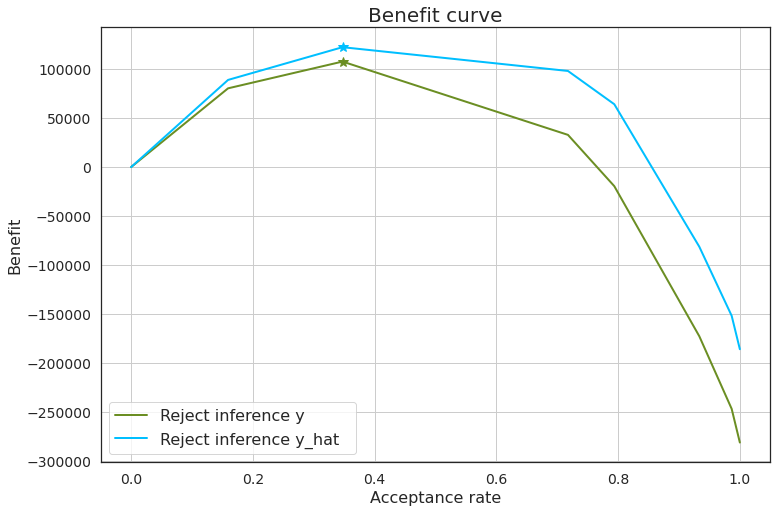

In [13]:
benefit_plot(X_train_with_rej_tree)

More complex model

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
#define model architecture
arc = GradientBoostingClassifier(learning_rate=0.2)
#Step1: train model
model_boosting = arc.fit(X_train[short_list], y_train)

stop_crit = [0] * len(short_list)
while True:
    X_train_all = X_train[short_list]
    X_train_all['weight'] = 1
    y_train_all = pd.DataFrame(y_train)
    
    
    #Step2: score rejected clients    
    weights_rej = model_boosting.predict_proba(X_train_rej[short_list])[:,1]

    
    #Step3: simulate target event for rejected clients
        #duplicate the rows 
    X_train_rej_inf_0 = X_train_rej[short_list]
    X_train_rej_inf_1 = X_train_rej[short_list]
        #assign each target equal 0 and 1
    y_train_rej_inf_0 = pd.DataFrame(np.zeros(shape=len(weights_rej)), columns= ['def'])
    y_train_rej_inf_1 = pd.DataFrame(np.ones(shape=len(weights_rej)), columns= ['def'])
        #assign weight equal to p_i and 1 - p_i for every duplicated row    
    X_train_rej_inf_1['weight'] = weights_rej
    X_train_rej_inf_0['weight'] = 1 - weights_rej

    
    #Step4: retrain model on united dataset
    X_train_all = pd.concat((X_train_all, X_train_rej_inf_1, X_train_rej_inf_0))
    y_train_all = pd.concat((y_train_all, y_train_rej_inf_1, y_train_rej_inf_0))

    model_boosting = arc.fit(X_train_all[short_list], y_train_all, sample_weight = list(X_train_all['weight']))
    
    #check that models are close in terms of parameters value
    if np.abs(stop_crit - model_boosting.feature_importances_).all() <= 1e-4:
        break

    stop_crit = model_boosting.feature_importances_


In [16]:
#define df with estimations
X_train_rej['y_hat'] = model_boosting.predict_proba(X_train_rej[short_list])[:,1]
X_train['y_hat'] = y_train

X_train_rej['y'] = y_train_rej
X_train['y'] = y_train

X_train_with_rej = X_train_rej
X_train_with_rej = pd.concat((X_train_with_rej, X_train))
X_train_with_rej['prob'] = model_boosting.predict_proba(X_train_with_rej[short_list])[:,1]
X_train_with_rej.shape
X_train_with_rej_boost = X_train_with_rej.copy()

In [17]:
print('Gini for model: ', roc_auc_score(X_train_with_rej_boost.y, X_train_with_rej_boost.prob))

Gini for model:  0.7067065722857836


___
**Plot benefit curve** 

Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -36406.96


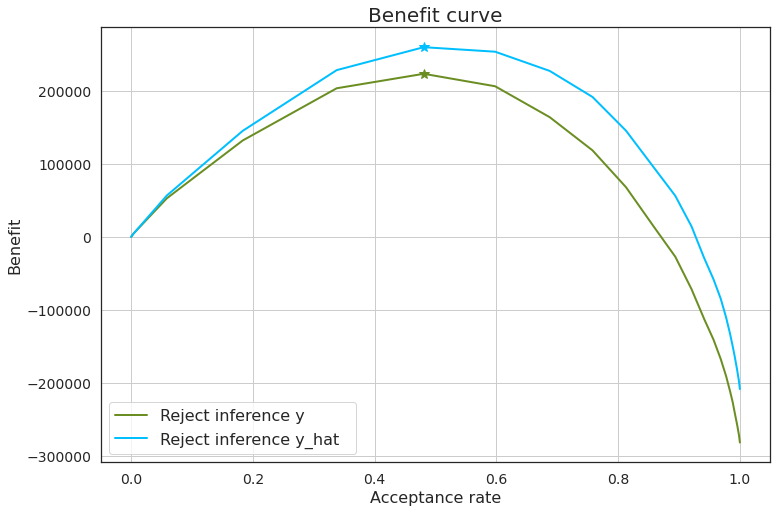

In [18]:
benefit_plot(X_train_with_rej_boost)

Plot benefit curve for two cases to compare them

Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -36406.96
Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -14696.18


<Figure size 864x576 with 0 Axes>

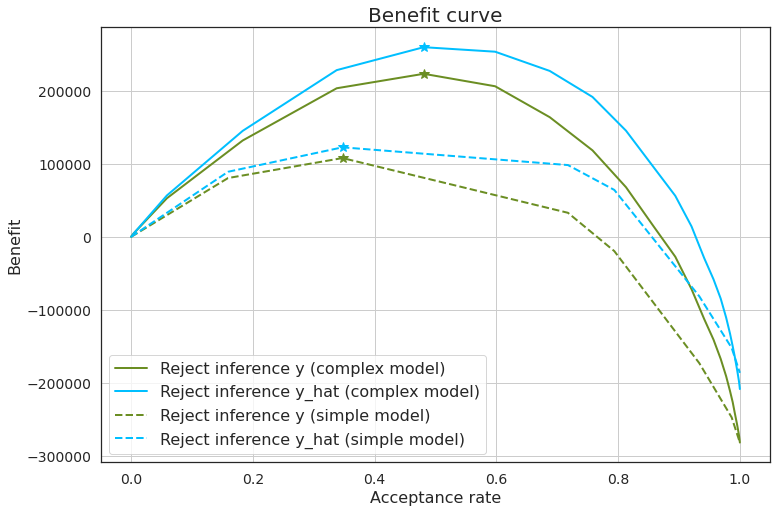

In [19]:
plt.figure(figsize=(12,8))

benefit_plot(X_train_with_rej_boost, leg='(complex model)')
benefit_plot(X_train_with_rej_tree, leg='(simple model)', linest='--')
plt.grid();

### Metalearning

In [20]:
X_train_with_rej_tree.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,y_hat,y,prob
0,115.29,24.27,4200,38500.0,6.0,60,0,8.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.178972,0,0.178972
1,277.25,0.00,8000,120000.0,1.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.069662,0,0.069662
2,647.42,0.00,25000,92800.0,7.0,60,0,7.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.248689,1,0.248689
3,105.91,0.00,3000,50000.0,4.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.137564,0,0.137564
4,98.78,0.31,2825,96000.0,10.0,36,2,1.000000,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.069662,0,0.069662


In [21]:
X_train_with_rej_boost.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,y_hat,y,prob
0,115.29,24.27,4200,38500.0,6.0,60,0,8.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131653,0,0.131653
1,277.25,0.00,8000,120000.0,1.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.064693,0,0.064693
2,647.42,0.00,25000,92800.0,7.0,60,0,7.000000,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.149854,1,0.149854
3,105.91,0.00,3000,50000.0,4.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.078838,0,0.078838
4,98.78,0.31,2825,96000.0,10.0,36,2,1.000000,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.047545,0,0.047545


In [22]:
#define df with estimations from both models
X_train_meta = X_train_with_rej[short_list]
X_train_meta['y'] = X_train_with_rej['y']

X_train_meta['y_hat_tree'] = X_train_with_rej_tree['y_hat']
X_train_meta['prob_tree'] = X_train_with_rej_tree['prob']

X_train_meta['y_hat_boost'] = X_train_with_rej_boost['y_hat']
X_train_meta['prob_boost'] = X_train_with_rej_boost['prob']

In [23]:
X_train_meta.tail()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,y,y_hat_tree,prob_tree,y_hat_boost,prob_boost
27995,655.18,17.76,18000,840000.0,10.0,36,0,12.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0,0.0,0.111094,0.0,0.106318
27996,467.35,21.46,14000,422000.0,1.0,36,1,2.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0,0.0,0.069662,0.0,0.092591
27997,1201.33,32.80,35000,400000.0,10.0,36,3,2.0,0,0,...,1.0,0.0,0.0,0.0,0.0,1,1.0,0.111094,1.0,0.282874
27998,1148.18,33.48,35000,400000.0,10.0,36,4,3.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0,0.0,0.111094,0.0,0.181993
27999,889.09,12.54,28000,1000000.0,1.0,36,2,2.0,0,0,...,1.0,0.0,0.0,0.0,0.0,0,0.0,0.069662,0.0,0.063987


In [24]:
X_train_meta.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,y,y_hat_tree,prob_tree,y_hat_boost,prob_boost
0,115.29,24.27,4200,38500.0,6.0,60,0,8.000000,0,0,...,0.0,0.0,0.0,0.0,1.0,0,0.178972,0.178972,0.131653,0.131653
1,277.25,0.00,8000,120000.0,1.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,1.0,0,0.069662,0.069662,0.064693,0.064693
2,647.42,0.00,25000,92800.0,7.0,60,0,7.000000,0,0,...,0.0,0.0,0.0,1.0,0.0,1,0.248689,0.248689,0.149854,0.149854
3,105.91,0.00,3000,50000.0,4.0,36,0,6.967818,0,0,...,0.0,0.0,0.0,0.0,1.0,0,0.137564,0.137564,0.078838,0.078838
4,98.78,0.31,2825,96000.0,10.0,36,2,1.000000,0,0,...,1.0,0.0,0.0,0.0,0.0,0,0.069662,0.069662,0.047545,0.047545


In [25]:
#define flag of rejection for cliens
X_train_meta['rej_flag'] = X_train_meta.y_hat_tree.apply(lambda x: False if x==1 or x==0 else True)
X_train_meta_train = X_train_meta[X_train_meta['rej_flag'] == False]
X_train_meta_pred = X_train_meta[X_train_meta['rej_flag'] == True]

_Define meta data:_
* $𝐹𝑙𝑎𝑔=1$ if boosting prediction is closer to correct answer than tree prediction
* $𝐹𝑙𝑎𝑔=0$, otherwise

In [26]:
X_train_meta_train['flag'] = (np.abs(X_train_meta_train.prob_tree - X_train_meta_train.y) >= np.abs(X_train_meta_train.prob_boost - X_train_meta_train.y))

Prediction of an auxiliary classifier $P\_aux$ is in fact a probability that boosting is likely to be more precise for this particular client

In [27]:
model_tree_meta = DecisionTreeClassifier(random_state=0, max_depth = 6).fit(X_train_meta_train[short_list], X_train_meta_train['flag'])

X_train_meta_pred['flag'] = model_tree_meta.predict_proba(X_train_meta_pred[short_list])[:,1]

X_train_meta_pred['blend_y'] = (1 - X_train_meta_pred['flag']) * X_train_meta_pred.y_hat_tree +\
                                X_train_meta_pred['flag']*X_train_meta_pred.y_hat_boost
X_train_meta_train['blend_y'] = X_train_meta_train['y']

X_train_meta['y_hat'] = pd.concat((X_train_meta_pred['blend_y'], X_train_meta_train['blend_y']))



In [28]:
X_train_meta.head()

,installment,dti,funded_amnt,annual_inc,emp_length,term,inq_last_6mths,mths_since_recent_inq,delinq_2yrs,chargeoff_within_12_mths,...,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,y,y_hat_tree,prob_tree,y_hat_boost,prob_boost,rej_flag,y_hat
0,115.29,24.27,4200,38500.0,6.0,60,0,8.000000,0,0,...,0.0,0.0,1.0,0,0.178972,0.178972,0.131653,0.131653,True,0.146234
1,277.25,0.00,8000,120000.0,1.0,36,0,6.967818,0,0,...,0.0,0.0,1.0,0,0.069662,0.069662,0.064693,0.064693,True,0.065463
2,647.42,0.00,25000,92800.0,7.0,60,0,7.000000,0,0,...,0.0,1.0,0.0,1,0.248689,0.248689,0.149854,0.149854,True,0.179280
3,105.91,0.00,3000,50000.0,4.0,36,0,6.967818,0,0,...,0.0,0.0,1.0,0,0.137564,0.137564,0.078838,0.078838,True,0.087940
4,98.78,0.31,2825,96000.0,10.0,36,2,1.000000,0,0,...,0.0,0.0,0.0,0,0.069662,0.069662,0.047545,0.047545,True,0.057823


Plot all benefit curves with reconstructed target event

Metalearning : Max(benefit_y) -  Max(benefit_y_hat) = -24661.92
Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -36406.96
Metalearning : Max(benefit_y) -  Max(benefit_y_hat) = -12618.66
Reject inference : Max(benefit_y) -  Max(benefit_y_hat) = -14696.18


<Figure size 864x576 with 0 Axes>

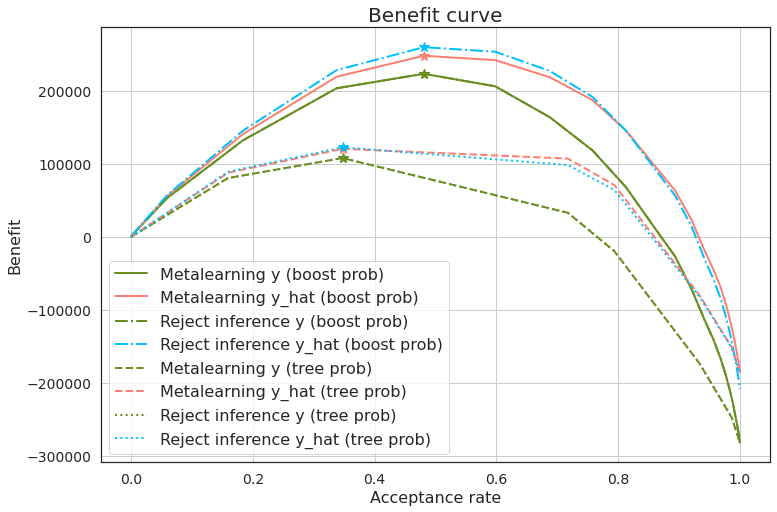

In [29]:
plt.figure(figsize=(12,8))


benefit_plot(X_train_meta, leg='(boost prob)', prob_col='prob_boost')
benefit_plot(X_train_with_rej_boost, leg='(boost prob)', linest='-.')

benefit_plot(X_train_meta, leg='(tree prob)', linest='--', prob_col='prob_tree')
benefit_plot(X_train_with_rej_tree, leg='(tree prob)', linest=':')


plt.grid();

In our example we get that the higher model quality metrics are, the higher is financial result (in general)